# ESP Paper

Here is all the code that went into the paper and everything required to create the plots as well.

In [1]:
# Run with ESP version 0.1.0

import esp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
from esp.lsst_utils import Bandpass
from esp.lsst_utils import BandpassDict
from esp.lsst_utils import Sed
from sklearn.neighbors import NearestNeighbors
from scipy.stats import binned_statistic, trim_mean
from sklearn.decomposition import PCA as sklPCA
from esp.spec_utils import specUtils
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load `sims_sed_library` and remove duplicate SEDs

In [2]:
home_dir = os.getenv('HOME')
galaxy_dir = '%s/lsst/DarwinX86/sims_sed_library/2016.01.26/galaxySED/' % home_dir
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(galaxy_dir)

File On 100 out of 959
File On 200 out of 959
File On 300 out of 959
File On 400 out of 959
File On 500 out of 959
File On 600 out of 959
File On 700 out of 959
File On 800 out of 959
File On 900 out of 959
Done loading spectra from file


In [3]:
new_spec_list = []
i = 0
for spec_obj in pca_obj.spec_list_orig:
    if i % 100 == 0:
        print('On Spectrum %i out of %i' % (i, len(pca_obj.spec_list_orig)))
    j = 0
    keep = True
    for new_spec_obj in new_spec_list:
        spec_flux = new_spec_obj.flambda
        if np.array_equal(np.array(spec_obj.flambda), spec_flux):
            #print(i,j) ## Uncomment to see which SEDs match to one another
            keep = False
        elif len(np.where(np.isclose(np.array(spec_obj.flambda), 
                                     spec_flux, atol=0., rtol=1e-5) == True)[0]) >= (0.9*6900):
            #print(i,j) ## Uncomment to see which SEDs match to one another
            keep = False
        else:
            j+=1
    
    if keep is True:
        new_spec_list.append(spec_obj)
    i += 1
print(len(new_spec_list))

On Spectrum 0 out of 959
On Spectrum 100 out of 959
On Spectrum 200 out of 959
On Spectrum 300 out of 959
On Spectrum 400 out of 959
On Spectrum 500 out of 959
On Spectrum 600 out of 959
On Spectrum 700 out of 959
On Spectrum 800 out of 959
On Spectrum 900 out of 959
789


## What is the resolution of the spectra and what do they look like?

In [5]:
resolution = new_spec_list[0].wavelen[1:] - new_spec_list[0].wavelen[:-1]

In [6]:
print(new_spec_list[190].name)
print(new_spec_list[240].name)
print(new_spec_list[360].name)
print(new_spec_list[686].name)
print(np.where(new_spec_list[0].wavelen <= 2400.))

Burst.50E09.1Z.spec.gz
Const.10E09.0005Z.spec.gz
Exp.15E06.002Z.spec.gz
Inst.32E08.25Z.spec.gz
(array([   0,    1,    2, ..., 6558, 6559, 6560]),)


In [6]:
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 

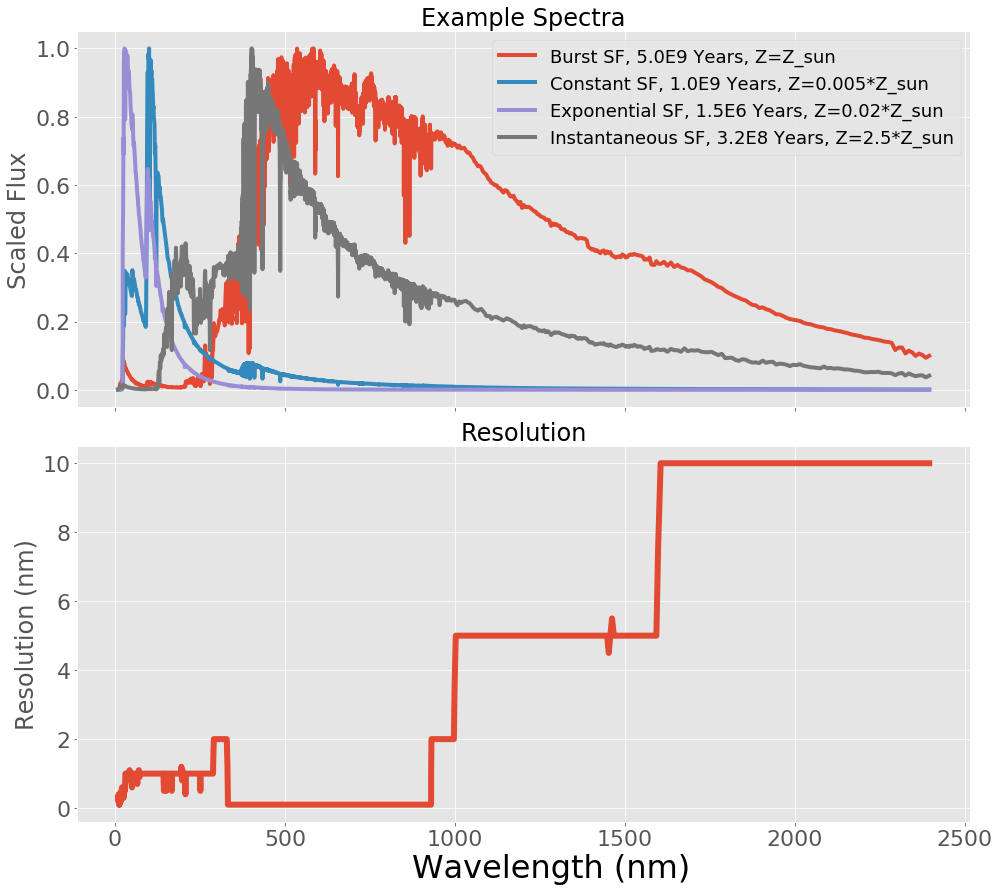

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14,12))

fig.text(0.55, -0.02, 'Wavelength (nm)', ha='center', size=32)

ax[0].plot(new_spec_list[0].wavelen[:6561], 
           (new_spec_list[190].flambda/np.max(new_spec_list[190].flambda))[:6561], lw=4,
          label='Burst SF, 5.0E9 Years, Z=Z_sun')
ax[0].plot(new_spec_list[0].wavelen[:6561], 
           (new_spec_list[240].flambda/np.max(new_spec_list[240].flambda))[:6561], lw=4,
          label='Constant SF, 1.0E9 Years, Z=0.005*Z_sun')
ax[0].plot(new_spec_list[0].wavelen[:6561], 
           (new_spec_list[360].flambda/np.max(new_spec_list[360].flambda))[:6561], lw=4,
          label='Exponential SF, 1.5E6 Years, Z=0.02*Z_sun')
ax[0].plot(new_spec_list[0].wavelen[:6561], 
           (new_spec_list[686].flambda/np.max(new_spec_list[686].flambda))[:6561], lw=4,
          label='Instantaneous SF, 3.2E8 Years, Z=2.5*Z_sun')
ax[0].set_ylabel('Scaled Flux', size=24)
ax[0].set_title('Example Spectra', size=24)
ax[0].legend(fontsize=18)



ax[1].plot(new_spec_list[0].wavelen[:6561], resolution[:6561], label='Resolution', lw=6)
ax[1].set_title('Resolution', size=24)
ax[1].set_ylabel('Resolution (nm)', size=24)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_0.png')

## Load Bandpasses and Create Artificial Bandpasses beyond the ugrizy of LSST

In [4]:
bandpass_dir = '%s/lsst/DarwinX86/throughputs/2016.12.13/baseline/' % home_dir
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

In [5]:
blue_sb_1 = np.zeros(13000)
blue_sb_1[0:500] += 1.
#blue_sb_1[:100] += 1.
blue_sb_2 = np.zeros(13000)
blue_sb_2[500:1000] += 1.
#blue_sb_2[100:200] += 1.

blue_sb_3 = np.zeros(13000)
blue_sb_3[1000:1500] += 1.
blue_sb_4 = np.zeros(13000)
blue_sb_4[1500:2000] += 1.

red_sb_1 = np.zeros(13000)
red_sb_1[11000:11500] += 1.
#red_sb_1[1100:1200] += 1.
red_sb_2 = np.zeros(13000)
red_sb_2[11500:12000] += 1.
#red_sb_2[1200:] += 1.

red_sb_3 = np.zeros(13000)
red_sb_3[12000:12500] += 1.
red_sb_4 = np.zeros(13000)
red_sb_4[12500:13000] += 1.

blue_bandpass_1 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=blue_sb_1)
blue_bandpass_2 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=blue_sb_2)
blue_bandpass_3 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=blue_sb_3)
blue_bandpass_4 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=blue_sb_4)
red_bandpass_1 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=red_sb_1)
red_bandpass_2 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=red_sb_2)
red_bandpass_3 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=red_sb_3)
red_bandpass_4 = Bandpass(wavelen=np.arange(100, 1400, .1), sb=red_sb_4)

In [6]:
new_bandpass_dict = BandpassDict([
                                  blue_bandpass_1, blue_bandpass_3, 
                                  #blue_bandpass_3, blue_bandpass_4,
                                  bandpass_dict['u'], bandpass_dict['g'], 
                                  bandpass_dict['r'], bandpass_dict['i'], bandpass_dict['z'], 
                                  bandpass_dict['y'], #red_bandpass_1, red_bandpass_2, 
                                  red_bandpass_2, red_bandpass_4
                                 ],
                                ['blue_1', #'blue_2', 
                                 'blue_3', #'blue_4', 
                                 'u', 'g', 'r', 'i', 'z', 'y', 
                                 'red_2',#'red_2', 
                                 'red_4', #'red_4'
                                ])

In [7]:
pca_obj.spec_list_orig = new_spec_list

## Define functions for later

In [8]:
def choose_training_and_test_set(pca_obj, bandpass_dict, min_wavelen, max_wavelen, 
                                 rand_print=False):
    rand_choice = np.random.choice(np.arange(len(pca_obj.spec_list_orig)), size=60, replace=False)
    if rand_print is True:
        print(rand_choice)
    sed_list = []
    names = []
    for row in rand_choice:
        #print row
        sed_list.append(pca_obj.spec_list_orig[row])
        names.append(sed_list[-1].name)
    training_list = sed_list[:10]
    training_names = names[:10]
    test_list = sed_list[10:]
    test_names = names[10:]
    
    training_colors = []
    test_colors = []
    
    for train_sed in training_list:
        
        train_mags = bandpass_dict.magListForSed(train_sed)
        
        colors = [train_mags[x] - train_mags[x+1] for x in range(len(train_mags)-1)]
        training_colors.append(colors)        
        
    
    min_idx = np.where(test_list[0].wavelen < min_wavelen)[0][-1] + 1
    max_idx = np.where(test_list[0].wavelen > max_wavelen)[0][0]
    test_fluxes = []
    
    for test_sed in test_list:
        
        test_fluxes.append(pca_obj.scale_spectrum(test_sed.flambda[min_idx:max_idx]))
        
        test_mags = bandpass_dict.magListForSed(test_sed)
        
        colors = [test_mags[x] - test_mags[x+1] for x in range(len(test_mags)-1)]
        test_colors.append(colors)
    test_colors = np.array(test_colors)
    test_fluxes = np.array(test_fluxes)
        
    return training_colors, training_list, training_names, test_list, test_names, test_fluxes, test_colors

In [9]:
from sklearn.linear_model import LinearRegression

def linear_interpolation_spectra(training_colors, test_colors, training_spectra, 
                                 bandpass_dict, min_wavelen, max_wavelen):
    lin_reg = LinearRegression()
    su = specUtils()
    
    training_fluxes = []
    for train_spec in training_spectra:
        training_fluxes.append(train_spec.flambda)
        
    min_idx = np.where(training_spectra[0].wavelen < min_wavelen)[0][-1] + 1
    max_idx = np.where(training_spectra[0].wavelen > max_wavelen)[0][0]
        
    lin_reg.fit(training_colors, training_fluxes)
    test_list = lin_reg.predict(test_colors)
    test_fluxes = []
    test_colors = []
    for test_flux in test_list:
        
        test_sed = Sed()
        for test_flux_bin in range(len(test_flux)):
            if test_flux[test_flux_bin] < 0.:
                test_flux[test_flux_bin] = 0.
                
        test_sed.setSED(wavelen=training_spectra[0].wavelen[min_idx:max_idx], flambda=test_flux[min_idx:max_idx])
        
        test_fluxes.append(su.scale_spectrum(test_sed.flambda))
        
        test_mags = bandpass_dict.magListForSed(test_sed)
        
        colors = [test_mags[x] - test_mags[x+1] for x in range(len(test_mags)-1)]
        test_colors.append(colors)
    
    return test_fluxes, test_colors

In [10]:
def calc_dist_bins(distances, results, n_bins):
    #bin_vals = [(float(i)/n_bins)*np.max(distances) for i in range(n_bins)]
    bin_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 
                0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6]
    bin_vals.append(float(np.max(distances)))
    idx_sort = distances.argsort()
    dist_sort = distances[idx_sort]
    #z_true_sort = z_true[idx_sort]
    results_sort = results[idx_sort]
    idx_bins = dist_sort.searchsorted(bin_vals)
    #print idx_bins
    results_binned = [results_sort[idx_bins[i]:idx_bins[i+1]] for i in range(len(bin_vals)-1)]
    return bin_vals, results_binned

In [11]:
def mean_dist_results(results_binned):
    mean_results = [np.mean(x) for x in results_binned]
    return np.array(mean_results)

In [12]:
def median_dist_results(results_binned):
    median_results = [np.median(x) for x in results_binned]
    return np.array(median_results)

## Test 1: Optical Wavelengths

In [17]:
np.random.seed(2314)

li_flux_results = np.zeros((25000, 6071))
nn_flux_u_results = np.zeros((25000, 6071))
#nn_flux_2u_results = np.zeros((25000, 6071))
nn_flux_2d_results = np.zeros((25000, 6071))
#nn_flux_4u_results = np.zeros((25000, 6071))
#nn_flux_4d_results = np.zeros((25000, 6071))
gp_exp_flux_results = np.zeros((25000, 6071))
gp_sq_exp_flux_results = np.zeros((25000, 6071))
gp_matern_32_flux_results = np.zeros((25000, 6071))
gp_matern_52_flux_results = np.zeros((25000, 6071))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []

test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []

distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 299.
max_wavelen = 1200.
n_colors = 5
n_comps = 9

for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))
    
    #print 'Linear Interp'
    li_spec, li_colors = linear_interpolation_spectra(colors, test_colors, new_pca_obj.spec_list_orig, 
                                                      bandpass_dict, min_wavelen, max_wavelen)
    li_flux_results[i*50:(i+1)*50] = np.abs(np.array((li_spec - test_fluxes)/test_fluxes))
    
    #print 'Nearest Neighbor Results'
    nn_obj = esp.nearestNeighborEstimate(new_pca_obj, bandpass_dict, test_colors)
    nn_spec = nn_obj.nn_predict(1)
    nn_flux_u_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(2)
    #nn_flux_2u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
    nn_spec = nn_obj.nn_predict(2, knr_args=dict(weights='distance'))
    nn_flux_2d_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(4)
    #nn_flux_4u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
    #nn_spec = nn_obj.nn_predict(4, knr_args=dict(weights='distance'))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_32_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)


test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

Run 0


/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/esp/lsst_utils/Sed.py:1399: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*numpy.log10(fluxes) - self.zp
/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Run 20
Run 40
Run 60
Run 80
Run 100
Run 120
Run 140
Run 160
Run 180
Run 200
Run 220
Run 240
Run 260
Run 280
Run 300
Run 320
Run 340
Run 360
Run 380
Run 400
Run 420
Run 440
Run 460
Run 480


In [14]:
np.random.seed(2314)

#li_flux_results = np.zeros((25000, 6071))
#nn_flux_u_results = np.zeros((25000, 6071))
#nn_flux_2u_results = np.zeros((25000, 6071))
#nn_flux_2d_results = np.zeros((25000, 6071))
#nn_flux_4u_results = np.zeros((25000, 6071))
#nn_flux_4d_results = np.zeros((25000, 6071))
gp_exp_flux_results = np.zeros((25000, 6071))
gp_sq_exp_flux_results = np.zeros((25000, 6071))
#gp_matern_32_flux_results = np.zeros((25000, 6071))
#gp_matern_52_flux_results = np.zeros((25000, 6071))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []

test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []

distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 299.
max_wavelen = 1200.
n_colors = 5
n_comps = 9

for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))
    
    #print 'Linear Interp'
#    li_spec, li_colors = linear_interpolation_spectra(colors, test_colors, new_pca_obj.spec_list_orig, 
#                                                      bandpass_dict, min_wavelen, max_wavelen)
#    li_flux_results[i*50:(i+1)*50] = np.abs(np.array((li_spec - test_fluxes)/test_fluxes))
    
    #print 'Nearest Neighbor Results'
#    nn_obj = esp.nearestNeighborEstimate(new_pca_obj, bandpass_dict, test_colors)
#    nn_spec = nn_obj.nn_predict(1)
#    nn_flux_u_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(2)
    #nn_flux_2u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
#    nn_spec = nn_obj.nn_predict(2, knr_args=dict(weights='distance'))
#    nn_flux_2d_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(4)
    #nn_flux_4u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
    #nn_spec = nn_obj.nn_predict(4, knr_args=dict(weights='distance'))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
#    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
#    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
#    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
#    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
#    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
#    test_matern_32_params.append(gp_spec.params)
    
#    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
#    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
#    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
#    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
#    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
#    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)


test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

Run 0
Run 20
Run 40
Run 60
Run 80
Run 100
Run 120
Run 140
Run 160
Run 180
Run 200
Run 220
Run 240
Run 260
Run 280
Run 300
Run 320
Run 340
Run 360
Run 380
Run 400
Run 420
Run 440
Run 460
Run 480


In [ ]:
[array([-11.02207729,   4.77361603]), array([-13.96023833,   2.13156115]), array([-17.59610534,  -0.96467728]), array([-19.79497933, -13.27023188]), array([-21.28017721, -13.80637852]), array([-21.74208749, -14.16324311]), array([-22.11764147, -14.36039222]), array([-23.05681041, -15.46075091]), array([-24.84448021, -15.5739952 ])]
[array([-11.2550589 ,   4.37618544]), array([-15.16269104,  -0.17042565]), array([-18.63210908,  -2.69566832]), array([-19.54205714,  -5.57521916]), array([-20.66959493,  -5.5241298 ]), array([-22.10726755,  -5.23304072]), array([-23.6345675 , -12.51136918]), array([-24.38139955, -13.33114988]), array([-24.98276997, -14.42287437])]
[array([-11.25444705,   4.48069245]), array([-15.04177928,  -0.45475115]), array([-17.6286331 ,  -1.45762491]), array([-19.45297358,  -4.82311417]), array([-20.36503317, -12.79350627]), array([-21.33194789, -13.32536929]), array([-22.28499836, -13.51599869]), array([-22.70957049, -13.55544863]), array([-24.52930451, -13.60538845])]
[array([-11.44655224,   4.06530313]), array([-16.22874545,  -0.97132244]), array([-19.38768499,  -6.60459258]), array([-19.6774699,  -4.7427898]), array([-19.77607617,  -9.63081001]), array([-21.31841287,  -8.50492599]), array([-22.11244633,  -9.13452811]), array([-22.88324644, -13.69198587]), array([-24.85286842, -14.27590948])]
/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
[array([-11.35058398,   4.42537694]), array([-14.84507009,  -0.23824238]), array([-18.06283476,  -2.71023966]), array([-20.32512608,  -6.34834806]), array([-20.79609481,  -6.00838321]), array([-21.51965251,  -3.89801573]), array([-22.48659084,  -5.99184903]), array([-24.12463544, -11.71187796]), array([-26.88263336, -14.37848589])]

In [15]:
print("Calculating overall means")

gp_exp_flux_mean = np.mean(gp_exp_flux_results)
nn_flux_u_mean = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean = np.mean(gp_sq_exp_flux_results)
nn_flux_2d_mean = np.mean(nn_flux_2d_results)
#nn_flux_2u_mean = np.mean(nn_flux_2u_results)
#nn_flux_4d_mean = np.mean(nn_flux_4d_results)
#nn_flux_4u_mean = np.mean(nn_flux_4u_results)
li_flux_mean = np.mean(li_flux_results)
gp_matern_32_flux_mean = np.mean(gp_matern_32_flux_results)
gp_matern_52_flux_mean = np.mean(gp_matern_52_flux_results)

Calculating overall means


NameError: name 'nn_flux_u_results' is not defined

In [16]:
print("Calculating overall means")

gp_exp_flux_mean = np.mean(gp_exp_flux_results)
#nn_flux_u_mean = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean = np.mean(gp_sq_exp_flux_results)
#nn_flux_2d_mean = np.mean(nn_flux_2d_results)
#nn_flux_2u_mean = np.mean(nn_flux_2u_results)
#nn_flux_4d_mean = np.mean(nn_flux_4d_results)
#nn_flux_4u_mean = np.mean(nn_flux_4u_results)
#li_flux_mean = np.mean(li_flux_results)
#gp_matern_32_flux_mean = np.mean(gp_matern_32_flux_results)
#gp_matern_52_flux_mean = np.mean(gp_matern_52_flux_results)

Calculating overall means


In [19]:
print("Calculating mean spectra")

gp_exp_flux_mean_spec = np.mean(gp_exp_flux_results, axis=0)
gp_sq_exp_flux_mean_spec = np.mean(gp_sq_exp_flux_results, axis=0)
nn_flux_u_mean_spec = np.mean(nn_flux_u_results, axis=0)
nn_flux_2d_mean_spec = np.mean(nn_flux_2d_results, axis=0)
#nn_flux_2u_mean_spec = np.mean(nn_flux_2u_results, axis=0)
#nn_flux_4d_mean_spec = np.mean(nn_flux_4d_results, axis=0)
#nn_flux_4u_mean_spec = np.mean(nn_flux_4u_results, axis=0)
li_flux_mean_spec = np.mean(li_flux_results, axis=0)
gp_matern_32_flux_mean_spec = np.mean(gp_matern_32_flux_results, axis=0)
gp_matern_52_flux_mean_spec = np.mean(gp_matern_52_flux_results, axis=0)

Calculating mean spectra


In [20]:
print("Calculating mean spectra")

gp_exp_flux_mean_dist = np.mean(gp_exp_flux_results, axis=1)
gp_sq_exp_flux_mean_dist = np.mean(gp_sq_exp_flux_results, axis=1)
gp_matern_32_flux_mean_dist = np.mean(gp_matern_32_flux_results, axis=1)
gp_matern_52_flux_mean_dist = np.mean(gp_matern_52_flux_results, axis=1)
nn_flux_u_mean_dist = np.mean(nn_flux_u_results, axis=1)
nn_flux_2d_mean_dist = np.mean(nn_flux_2d_results, axis=1)
li_flux_mean_dist = np.mean(li_flux_results, axis=1)

Calculating mean spectra


In [21]:
#Exponential Kernel 1st 3
print('Exponential')
print(np.mean(np.array(np.exp(test_exp_params))[:, 0], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_exp_params))[:, 1], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_exp_params))[:, 2], axis=0)*np.array([5., 1.]))
#Squared Exponential Kernel 1st 3
print('Squared Exponential')
print(np.mean(np.array(np.exp(test_sq_exp_params))[:, 0], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_sq_exp_params))[:, 1], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_sq_exp_params))[:, 2], axis=0)*np.array([5., 1.]))
#Matern 3/2 Kernel 1st 3
print('Matern 3/2')
print(np.mean(np.array(np.exp(test_matern_32_params))[:, 0], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_matern_32_params))[:, 1], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_matern_32_params))[:, 2], axis=0)*np.array([5., 1.]))
#Matern 5/2 Kernel 1st 3
print('Matern 5/2')
print(np.mean(np.array(np.exp(test_matern_52_params))[:, 0], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_matern_52_params))[:, 1], axis=0)*np.array([5., 1.]))
print(np.mean(np.array(np.exp(test_matern_52_params))[:, 2], axis=0)*np.array([5., 1.]))

Exponential
[  5.13662935e-05   6.16229323e+01]
[  1.58303512e-06   6.09446228e-01]
[  9.93519969e-08   1.22736736e-01]
Squared Exponential
[  1.65498340e-04   9.66212252e+00]
[  3.65785857e-05   2.14345205e+00]
[  9.93448226e-06   1.18819618e+00]
Matern 3/2
[  9.21177307e-04   2.56823430e+02]
[  6.58366258e-05   1.60376403e+01]
[  3.49375175e-05   3.69936584e+01]
Matern 5/2
[  2.75322559e-04   3.60135671e+01]
[  8.09316365e-05   8.94425269e+00]
[  3.38563023e-05   5.70794355e+00]


In [22]:
print(gp_exp_flux_mean)
print(gp_sq_exp_flux_mean)
print(gp_matern_32_flux_mean)
print(gp_matern_52_flux_mean)
print(nn_flux_u_mean)
print(nn_flux_2d_mean)
print(li_flux_mean)

0.0725325573089
0.0334792084461
0.0376008675272
0.0320099044064
0.0969591905896
0.0922874808829
0.0962248898827


In [17]:
print(gp_exp_flux_mean)
print(gp_sq_exp_flux_mean)
#print(gp_matern_32_flux_mean)
#print(gp_matern_52_flux_mean)
#print(nn_flux_u_mean)
#print(nn_flux_2d_mean)
#print(li_flux_mean)

0.0725284479597
0.0334778622608


In [23]:
gp_exp_argsort = np.argsort(gp_exp_flux_mean_dist)
gp_exp_trim_25_idx = gp_exp_argsort[6250:-6250]
print(np.mean(gp_exp_flux_mean_dist[gp_exp_trim_25_idx]))

gp_sq_exp_argsort = np.argsort(gp_sq_exp_flux_mean_dist)
gp_sq_exp_trim_25_idx = gp_sq_exp_argsort[6250:-6250]
print(np.mean(gp_sq_exp_flux_mean_dist[gp_sq_exp_trim_25_idx]))

gp_matern_32_argsort = np.argsort(gp_matern_32_flux_mean_dist)
gp_matern_32_trim_25_idx = gp_matern_32_argsort[6250:-6250]
print(np.mean(gp_matern_32_flux_mean_dist[gp_exp_trim_25_idx]))

gp_matern_52_argsort = np.argsort(gp_matern_52_flux_mean_dist)
gp_matern_52_trim_25_idx = gp_matern_52_argsort[6250:-6250]
print(np.mean(gp_matern_52_flux_mean_dist[gp_matern_52_trim_25_idx]))

nn_flux_u_argsort = np.argsort(nn_flux_u_mean_dist)
nn_flux_u_trim_25_idx = nn_flux_u_argsort[6250:-6250]
print(np.mean(nn_flux_u_mean_dist[nn_flux_u_trim_25_idx]))

nn_flux_2d_argsort = np.argsort(nn_flux_2d_mean_dist)
nn_flux_2d_trim_25_idx = nn_flux_2d_argsort[6250:-6250]
print(np.mean(nn_flux_2d_mean_dist[nn_flux_2d_trim_25_idx]))

li_flux_argsort = np.argsort(li_flux_mean_dist)
li_flux_trim_25_idx = li_flux_argsort[6250:-6250]
print(np.mean(li_flux_mean_dist[li_flux_trim_25_idx]))

0.040415899425
0.0208915343935
0.0262856974878
0.0210929388887
0.0738637877199
0.061807920037
0.0665429635533


/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


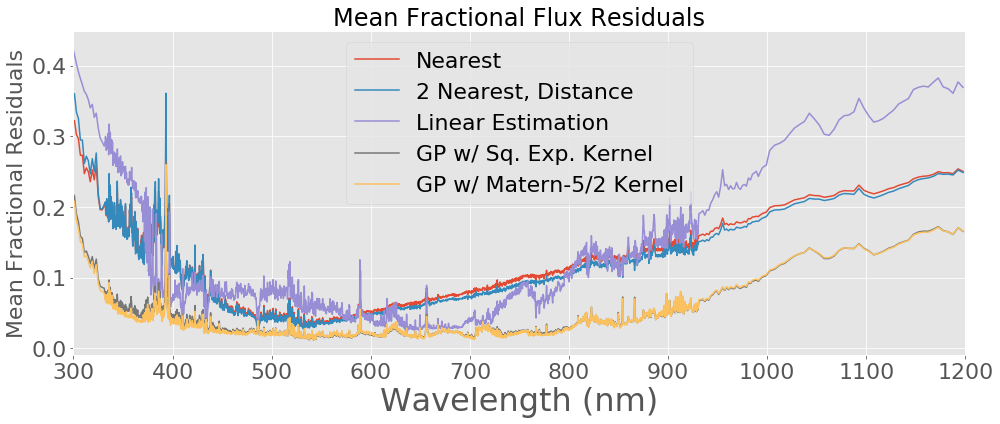

In [24]:
fig = plt.figure(figsize=(14, 6))

ax = plt.gca()
ax.set_xlabel('Wavelength (nm)', size=32)
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 

fig.add_subplot(1,1,1)
plt.plot(new_pca_obj.wavelengths, nn_flux_u_mean_spec, label='Nearest')
plt.plot(new_pca_obj.wavelengths, nn_flux_2d_mean_spec, label='2 Nearest, Distance')
plt.plot(new_pca_obj.wavelengths, li_flux_mean_spec, label='Linear Estimation')
plt.plot(new_pca_obj.wavelengths, gp_sq_exp_flux_mean_spec, label='GP w/ Sq. Exp. Kernel')
plt.plot(new_pca_obj.wavelengths, gp_matern_52_flux_mean_spec, label='GP w/ Matern-5/2 Kernel')


plt.legend(fontsize=22)
plt.title('Mean Fractional Flux Residuals', size=24)
plt.ylabel('Mean Fractional Residuals', size=22)
plt.xlim(300, 1200)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_2.png')

/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


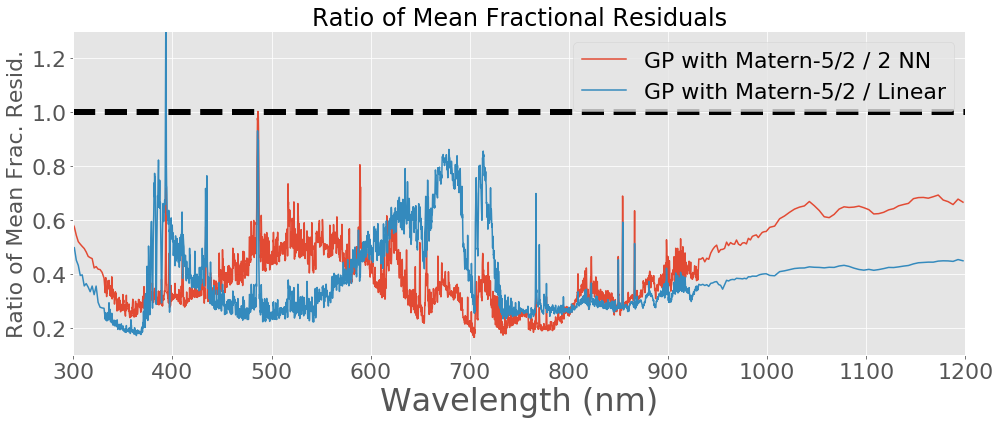

In [25]:
fig = plt.figure(figsize=(14, 6))

ax = plt.gca()
ax.set_xlabel('Wavelength (nm)', size=32)
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22)

fig.add_subplot(1,1,1)
plt.plot(new_pca_obj.wavelengths, gp_matern_52_flux_mean_spec/nn_flux_2d_mean_spec, label='GP with Matern-5/2 / 2 NN')
plt.plot(new_pca_obj.wavelengths, gp_matern_52_flux_mean_spec/li_flux_mean_spec, label='GP with Matern-5/2 / Linear')
plt.legend(fontsize=22)
plt.title('Ratio of Mean Fractional Residuals', size=24)
plt.ylabel('Ratio of Mean Frac. Resid.', size=22)
plt.hlines(1.0, 300, 1200, colors='k', linestyles='dashed', lw=6)
plt.xlim(300, 1200)
plt.ylim(0.1, 1.3)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_3.png')

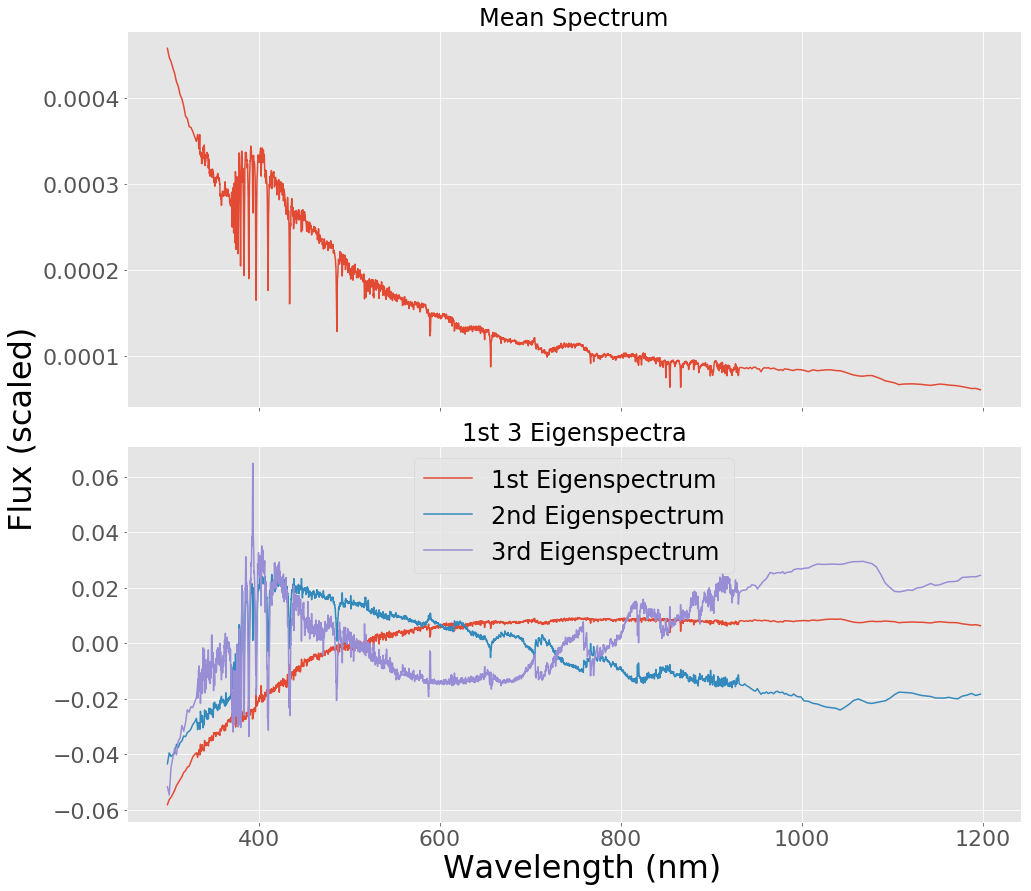

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14,12))

fig.text(0.55, -0.02, 'Wavelength (nm)', ha='center', size=32)
fig.text(-0.02, 0.5, 'Flux (scaled)', va='center', rotation='vertical', size=32)

ax[0].plot(new_pca_obj.wavelengths, new_pca_obj.mean_spec, label='Mean Spectrum')
ax[0].set_title('Mean Spectrum', size=24)

ax[1].plot(new_pca_obj.wavelengths, new_pca_obj.eigenspectra[0], label='1st Eigenspectrum')

ax[1].plot(new_pca_obj.wavelengths, new_pca_obj.eigenspectra[1], label='2nd Eigenspectrum')

ax[1].plot(new_pca_obj.wavelengths, new_pca_obj.eigenspectra[2], label='3rd Eigenspectrum')
plt.legend(fontsize=24)
plt.title('1st 3 Eigenspectra', size=24)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_1.png')

## Test with larger part of spectrum

In [27]:
np.random.seed(2314)

li_flux_results = np.zeros((25000, 6431))
nn_flux_u_results = np.zeros((25000, 6431))
nn_flux_2d_results = np.zeros((25000, 6431))
gp_exp_flux_results = np.zeros((25000, 6431))
gp_sq_exp_flux_results = np.zeros((25000, 6431))
gp_matern_32_flux_results = np.zeros((25000, 6431))
gp_matern_52_flux_results = np.zeros((25000, 6431))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []
test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []
distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 99.
max_wavelen = 2400.
n_colors = 5
n_comps = 9
for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors
    
    #print 'Linear Interp'
    li_spec, li_colors = linear_interpolation_spectra(colors, test_colors, new_pca_obj.spec_list_orig, 
                                                      bandpass_dict, min_wavelen, max_wavelen)
    li_flux_results[i*50:(i+1)*50] = np.abs(np.array((li_spec - test_fluxes)/test_fluxes))
    
    #print 'Nearest Neighbor Results'
    nn_obj = esp.nearestNeighborEstimate(new_pca_obj, bandpass_dict, test_colors)
    nn_spec = nn_obj.nn_predict(1)
    nn_flux_u_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    nn_spec = nn_obj.nn_predict(2, knr_args=dict(weights='distance'))
    nn_flux_2d_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_32_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)


test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

Run 0


/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/esp/lsst_utils/Sed.py:1399: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*numpy.log10(fluxes) - self.zp
/Users/Bryce/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Run 20
Run 40
Run 60
Run 80
Run 100
Run 120
Run 140
Run 160
Run 180
Run 200
Run 220
Run 240
Run 260
Run 280
Run 300
Run 320
Run 340
Run 360
Run 380
Run 400
Run 420
Run 440
Run 460
Run 480


In [28]:
print("Calculating overall means")

gp_exp_flux_mean = np.mean(gp_exp_flux_results)
nn_flux_u_mean = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean = np.mean(gp_sq_exp_flux_results)
nn_flux_2d_mean = np.mean(nn_flux_2d_results)
li_flux_mean = np.mean(li_flux_results)
gp_matern_32_flux_mean = np.mean(gp_matern_32_flux_results)
gp_matern_52_flux_mean = np.mean(gp_matern_52_flux_results)

Calculating overall means


In [29]:
print(gp_exp_flux_mean)
print(gp_sq_exp_flux_mean)
print(gp_matern_32_flux_mean)
print(gp_matern_52_flux_mean)
print(nn_flux_u_mean)
print(nn_flux_2d_mean)
print(li_flux_mean)

0.443852308433
0.803646103625
0.576154413666
0.666631915825
0.270972271859
0.335837186692
0.565081429947


In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_dist_2 = np.mean(gp_exp_flux_results, axis=1)
gp_sq_exp_flux_mean_dist_2 = np.mean(gp_sq_exp_flux_results, axis=1)
nn_flux_u_mean_dist_2 = np.mean(nn_flux_u_results, axis=1)
nn_flux_2d_mean_dist_2 = np.mean(nn_flux_2d_results, axis=1)
li_flux_mean_dist_2 = np.mean(li_flux_results, axis=1)
gp_matern_32_flux_mean_dist_2 = np.mean(gp_matern_32_flux_results, axis=1)
gp_matern_52_flux_mean_dist_2 = np.mean(gp_matern_52_flux_results, axis=1)

In [ ]:
gp_exp_argsort = np.argsort(gp_exp_flux_mean_dist_2)
gp_exp_trim_25_idx = gp_exp_argsort[6250:-6250]
print(np.mean(gp_exp_flux_mean_dist_2[gp_exp_trim_25_idx]))

gp_sq_exp_argsort = np.argsort(gp_sq_exp_flux_mean_dist_2)
gp_sq_exp_trim_25_idx = gp_sq_exp_argsort[6250:-6250]
print(np.mean(gp_sq_exp_flux_mean_dist_2[gp_sq_exp_trim_25_idx]))

gp_matern_32_argsort = np.argsort(gp_matern_32_flux_mean_dist_2)
gp_matern_32_trim_25_idx = gp_matern_32_argsort[6250:-6250]
print(np.mean(gp_matern_32_flux_mean_dist_2[gp_exp_trim_25_idx]))

gp_matern_52_argsort = np.argsort(gp_matern_52_flux_mean_dist_2)
gp_matern_52_trim_25_idx = gp_matern_52_argsort[6250:-6250]
print(np.mean(gp_matern_52_flux_mean_dist_2[gp_matern_52_trim_25_idx]))

nn_flux_u_argsort = np.argsort(nn_flux_u_mean_dist_2)
nn_flux_u_trim_25_idx = nn_flux_u_argsort[6250:-6250]
print(np.mean(nn_flux_u_mean_dist_2[nn_flux_u_trim_25_idx]))

nn_flux_2d_argsort = np.argsort(nn_flux_2d_mean_dist_2)
nn_flux_2d_trim_25_idx = nn_flux_2d_argsort[6250:-6250]
print(np.mean(nn_flux_2d_mean_dist_2[nn_flux_2d_trim_25_idx]))

li_flux_argsort = np.argsort(li_flux_mean_dist_2)
li_flux_trim_25_idx = li_flux_argsort[6250:-6250]
print(np.mean(li_flux_mean_dist_2[li_flux_trim_25_idx]))

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_spec_2 = np.mean(gp_exp_flux_results, axis=0)
gp_sq_exp_flux_mean_spec_2 = np.mean(gp_sq_exp_flux_results, axis=0)
nn_flux_u_mean_spec_2 = np.mean(nn_flux_u_results, axis=0)
nn_flux_2d_mean_spec_2 = np.mean(nn_flux_2d_results, axis=0)
li_flux_mean_spec_2 = np.mean(li_flux_results, axis=0)
gp_matern_32_flux_mean_spec_2 = np.mean(gp_matern_32_flux_results, axis=0)
gp_matern_52_flux_mean_spec_2 = np.mean(gp_matern_52_flux_results, axis=0)

In [ ]:
idx_300 = np.where(new_pca_obj.wavelengths >= 299.)[0][0]
idx_1200 = np.where(new_pca_obj.wavelengths <= 1200.)[0][-1]+1
print(np.mean(gp_exp_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_sq_exp_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_matern_32_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_matern_52_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(nn_flux_u_mean_spec_2[idx_300:idx_1200]))
print(np.mean(nn_flux_2d_mean_spec_2[idx_300:idx_1200]))
print(np.mean(li_flux_mean_spec_2[idx_300:idx_1200]))

## Test with artificial filters

In [ ]:
np.random.seed(2314)

gp_exp_flux_results = np.zeros((25000, 6431))
gp_sq_exp_flux_results = np.zeros((25000, 6431))
gp_matern_32_flux_results = np.zeros((25000, 6431))
gp_matern_52_flux_results = np.zeros((25000, 6431))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []
test_spectra_full = []
test_coeffs_full = []
test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []
distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 99.
max_wavelen = 2400.
n_colors = 9
n_comps = 9
for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, new_bandpass_dict)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, new_bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, new_bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_32_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, new_bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)

test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

In [ ]:
print("Calculating overall means")

gp_exp_flux_mean = np.mean(gp_exp_flux_results)
#nn_flux_u_mean = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean = np.mean(gp_sq_exp_flux_results)
#nn_flux_2d_mean = np.mean(nn_flux_2d_results)
#nn_flux_2u_mean = np.mean(nn_flux_2u_results)
#nn_flux_4d_mean = np.mean(nn_flux_4d_results)
#nn_flux_4u_mean = np.mean(nn_flux_4u_results)
#li_flux_mean = np.mean(li_flux_results)
gp_matern_32_flux_mean = np.mean(gp_matern_32_flux_results)
gp_matern_52_flux_mean = np.mean(gp_matern_52_flux_results)

In [ ]:
print(gp_sq_exp_flux_mean)
print(gp_exp_flux_mean)
#print(nn_flux_u_mean)
#print(nn_flux_2d_mean)
#print(li_flux_mean)
print(gp_matern_32_flux_mean)
print(gp_matern_52_flux_mean)

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_spec_3 = np.mean(gp_exp_flux_results, axis=0)
gp_sq_exp_flux_mean_spec_3 = np.mean(gp_sq_exp_flux_results, axis=0)
gp_matern_32_flux_mean_spec_3 = np.mean(gp_matern_32_flux_results, axis=0)
gp_matern_52_flux_mean_spec_3 = np.mean(gp_matern_52_flux_results, axis=0)
nn_flux_u_mean_spec_3 = np.mean(nn_flux_u_results, axis=0)
li_flux_mean_spec_3 = np.mean(li_flux_results, axis=0)

In [ ]:
idx_300 = np.where(new_pca_obj.wavelengths >= 299.)[0][0]
idx_1200 = np.where(new_pca_obj.wavelengths <= 1200.)[0][-1]+1
print(np.mean(gp_exp_flux_mean_spec_3[idx_300:idx_1200]))
print(np.mean(gp_sq_exp_flux_mean_spec_3[idx_300:idx_1200]))
print(np.mean(gp_matern_32_flux_mean_spec_3[idx_300:idx_1200]))
print(np.mean(gp_matern_52_flux_mean_spec_3[idx_300:idx_1200]))

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_dist_3 = np.mean(gp_exp_flux_results, axis=1)
gp_sq_exp_flux_mean_dist_3 = np.mean(gp_sq_exp_flux_results, axis=1)
nn_flux_u_mean_dist_3 = np.mean(nn_flux_u_results, axis=1)
#nn_flux_2d_mean_dist_3 = np.mean(nn_flux_2d_results, axis=1)
li_flux_mean_dist_3 = np.mean(li_flux_results, axis=1)
gp_matern_32_flux_mean_dist_3 = np.mean(gp_matern_32_flux_results, axis=1)
gp_matern_52_flux_mean_dist_3 = np.mean(gp_matern_52_flux_results, axis=1)

In [ ]:
gp_exp_argsort = np.argsort(gp_exp_flux_mean_dist_3)
gp_exp_trim_25_idx = gp_exp_argsort[6250:-6250]
print(np.mean(gp_exp_flux_mean_dist_3[gp_exp_trim_25_idx]))

gp_sq_exp_argsort = np.argsort(gp_sq_exp_flux_mean_dist_3)
gp_sq_exp_trim_25_idx = gp_sq_exp_argsort[6250:-6250]
print(np.mean(gp_sq_exp_flux_mean_dist_3[gp_sq_exp_trim_25_idx]))

gp_matern_32_argsort = np.argsort(gp_matern_32_flux_mean_dist_3)
gp_matern_32_trim_25_idx = gp_matern_32_argsort[6250:-6250]
print(np.mean(gp_matern_32_flux_mean_dist_3[gp_exp_trim_25_idx]))

gp_matern_52_argsort = np.argsort(gp_matern_52_flux_mean_dist_3)
gp_matern_52_trim_25_idx = gp_matern_52_argsort[6250:-6250]
print(np.mean(gp_matern_52_flux_mean_dist_3[gp_matern_52_trim_25_idx]))

In [ ]:
fig = plt.figure(figsize=(14, 12))

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_axis_bgcolor('white') 
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Wavelength (nm)', size=32)
ax.set_ylabel('Ratio of Mean Fractional Residuals', size=32)
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22)

fig.add_subplot(2,1,1)
plt.plot(new_pca_obj.wavelengths, gp_matern_32_flux_mean_spec_2/nn_flux_u_mean_spec_3, label='GP with Matern-3/2 / NN', lw=4)
plt.plot(new_pca_obj.wavelengths, gp_matern_32_flux_mean_spec_2/li_flux_mean_spec_3, label='GP with Matern-3/2 / Linear', lw=4)
plt.legend(fontsize=22)
plt.title('Only training with LSST filters', size=24)
plt.hlines(1.0, 99, 2400, colors='k', linestyles='dashed', lw=6)
plt.xlim(99, 2400)

fig.add_subplot(2,1,2)
plt.plot(new_pca_obj.wavelengths, gp_matern_32_flux_mean_spec_3/nn_flux_u_mean_spec_3, label='GP with Matern-3/2 / NN', lw=4)
plt.plot(new_pca_obj.wavelengths, gp_matern_32_flux_mean_spec_3/li_flux_mean_spec_3, label='GP with Matern-3/2 / Linear', lw=4)
plt.legend(fontsize=22)
plt.title('With additional training filters', size=24)
plt.hlines(1.0, 99, 2400, colors='k', linestyles='dashed', lw=6)
plt.xlim(99, 2400)
plt.ylim(0, 2)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_6.png')

## Look at distances from nearest neighbor

In [ ]:
np.random.seed(2314)

distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 99.
max_wavelen = 2400.
n_colors = 9
n_comps = 9
for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))

In [ ]:
use_distances = np.ravel(distances_all)

In [ ]:
n_bins = 25
bin_vals, gp_matern_52_dist_results = calc_dist_bins(use_distances, gp_matern_52_flux_mean_dist, n_bins)
bin_vals, nn_u_dist_results = calc_dist_bins(use_distances, nn_flux_u_mean_dist, n_bins)
bin_vals, nn_2d_dist_results = calc_dist_bins(use_distances, nn_flux_2d_mean_dist, n_bins)
bin_vals, li_dist_results = calc_dist_bins(use_distances, li_flux_mean_dist, n_bins)

In [ ]:
n_bins = 25
bin_vals, gp_matern_32_dist_results_3 = calc_dist_bins(use_distances, gp_matern_32_flux_mean_dist_3, n_bins)
bin_vals, nn_u_dist_results_3 = calc_dist_bins(use_distances, nn_flux_u_mean_dist_3, n_bins)
bin_vals, li_dist_results_3 = calc_dist_bins(use_distances, li_flux_mean_dist_3, n_bins)

In [ ]:
fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_axis_bgcolor('white') 
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_ylabel('Ratio of Mean Fractional Residuals', size=32)
ax.set_xlabel('Distance in mags to nearest neighbor', size=32)
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22)

fig.add_subplot(2,1,1)

plt.plot(bin_vals[:-1], mean_dist_results(gp_matern_52_dist_results)/mean_dist_results(nn_2d_dist_results), label='GP with Matern-5/2 / 2 NN', lw=8)
plt.plot(bin_vals[:-1], mean_dist_results(gp_matern_52_dist_results)/mean_dist_results(li_dist_results), label='GP with Matern-5/2 / LI', lw=8)
plt.xlim(0, 0.6)
plt.ylim(0, 2.)
plt.hlines(1.0, 0.0, 0.6, linestyles='dashed', lw=6)
plt.legend(fontsize=22)
plt.title('Ratio of Residual Errors in Test 1', size=32)

fig.add_subplot(2,1,2)

plt.plot(bin_vals[:-1], mean_dist_results(gp_matern_32_dist_results_3)/mean_dist_results(nn_u_dist_results_3), label='GP with Matern-3/2 / NN', lw=8)
plt.plot(bin_vals[:-1], mean_dist_results(gp_matern_32_dist_results_3)/mean_dist_results(li_dist_results_3), label='GP with Matern-3/2 / LI', lw=8)
plt.xlim(0, 0.6)
plt.ylim(0, 2.)
plt.hlines(1.0, 0.0, 0.6, linestyles='dashed', lw=6)
plt.legend(fontsize=22)
plt.title('Ratio of Residual Errors in Test 3', size=32)

plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_7.png')

In [ ]:
n, bins = np.histogram(use_distances, bins=bin_vals)

In [ ]:
np.sum(n[:12])/np.sum(n)

## Narrowband filters test

In [ ]:
filters = ['F344N', 'F502N', 'F658N', 'F892N']
narrow_band_dict = {}
total_wavelengths = []
for filt_name in filters:
    narrow_band = np.genfromtxt('narrowband_filters/HST_ACS_HRC.%s.dat' % filt_name, unpack=True)
    narrow_band[0] /= 10. # Convert to nanometers
    total_wavelengths.append(narrow_band[0])
    narrow_band_dict[filt_name] = narrow_band

In [ ]:
total_wavelengths = [x for y in total_wavelengths for x in y]

In [ ]:
narrow_bandpasses = []
for filt_name in filters:
    bandpass = np.zeros(len(total_wavelengths))
    min_idx = np.where(total_wavelengths == narrow_band_dict[filt_name][0][0])[0][0]
    max_idx = np.where(total_wavelengths == narrow_band_dict[filt_name][0][-1])[0][0]
    bandpass[min_idx:max_idx+1] = narrow_band_dict[filt_name][1]
    narrow_bandpasses.append(Bandpass(wavelen=np.array(total_wavelengths), sb=bandpass))

In [ ]:
narrow_bandpass_dict = BandpassDict(narrow_bandpasses, filters)

In [ ]:
np.random.seed(2314)

li_flux_results = np.zeros((25000, 6071))
nn_flux_u_results = np.zeros((25000, 6071))
#nn_flux_2u_results = np.zeros((25000, 6071))
nn_flux_2d_results = np.zeros((25000, 6071))
#nn_flux_4u_results = np.zeros((25000, 6071))
#nn_flux_4d_results = np.zeros((25000, 6071))
gp_exp_flux_results = np.zeros((25000, 6071))
gp_sq_exp_flux_results = np.zeros((25000, 6071))
gp_matern_32_flux_results = np.zeros((25000, 6071))
gp_matern_52_flux_results = np.zeros((25000, 6071))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []
test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []
distances_all = []


total_flagged = 0
n_runs = 500
min_wavelen = 299.
max_wavelen = 1200.
n_colors = 3
n_comps = 9

for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))
    
    #print 'Linear Interp'
    li_spec, li_colors = linear_interpolation_spectra(colors, test_colors, new_pca_obj.spec_list_orig, 
                                                      bandpass_dict, min_wavelen, max_wavelen)
    li_flux_results[i*50:(i+1)*50] = np.abs(np.array((li_spec - test_fluxes)/test_fluxes))
    
    #print 'Nearest Neighbor Results'
    nn_obj = esp.nearestNeighborEstimate(new_pca_obj, bandpass_dict, test_colors)
    nn_spec = nn_obj.nn_predict(1)
    nn_flux_u_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(2)
    #nn_flux_2u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
    nn_spec = nn_obj.nn_predict(2, knr_args=dict(weights='distance'))
    nn_flux_2d_results[i*50:(i+1)*50] = np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes))

    #nn_spec = nn_obj.nn_predict(4)
    #nn_flux_4u_results.append(np.abs(np.array((nn_spec.reconstruct_spectra(10) - test_fluxes)/test_fluxes)))
    #nn_spec = nn_obj.nn_predict(4, knr_args=dict(weights='distance'))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_32_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, bandpass_dict)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)


test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

In [ ]:
print("Calculating overall means")

gp_exp_flux_mean_nb = np.mean(gp_exp_flux_results)
nn_flux_u_mean_nb = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean_nb = np.mean(gp_sq_exp_flux_results)
nn_flux_2d_mean_nb = np.mean(nn_flux_2d_results)
li_flux_mean_nb = np.mean(li_flux_results)
gp_matern_32_flux_mean_nb = np.mean(gp_matern_32_flux_results)
gp_matern_52_flux_mean_nb = np.mean(gp_matern_52_flux_results)

In [ ]:
print(gp_exp_flux_mean_nb)
print(gp_sq_exp_flux_mean_nb)
print(gp_matern_32_flux_mean_nb)
print(gp_matern_52_flux_mean_nb)
print(nn_flux_u_mean_nb)
print(nn_flux_2d_mean_nb)
print(li_flux_mean_nb)

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_dist_nb = np.mean(gp_exp_flux_results, axis=1)
gp_sq_exp_flux_mean_dist_nb = np.mean(gp_sq_exp_flux_results, axis=1)
nn_flux_u_mean_dist_nb = np.mean(nn_flux_u_results, axis=1)
nn_flux_2d_mean_dist_nb = np.mean(nn_flux_2d_results, axis=1)
li_flux_mean_dist_nb = np.mean(li_flux_results, axis=1)
gp_matern_32_flux_mean_dist_nb = np.mean(gp_matern_32_flux_results, axis=1)
gp_matern_52_flux_mean_dist_nb = np.mean(gp_matern_52_flux_results, axis=1)

In [ ]:
gp_exp_argsort = np.argsort(gp_exp_flux_mean_dist_nb)
gp_exp_trim_25_idx = gp_exp_argsort[6250:-6250]
print(np.mean(gp_exp_flux_mean_dist_nb[gp_exp_trim_25_idx]))

gp_sq_exp_argsort = np.argsort(gp_sq_exp_flux_mean_dist_nb)
gp_sq_exp_trim_25_idx = gp_sq_exp_argsort[6250:-6250]
print(np.mean(gp_sq_exp_flux_mean_dist_nb[gp_sq_exp_trim_25_idx]))

gp_matern_32_argsort = np.argsort(gp_matern_32_flux_mean_dist_nb)
gp_matern_32_trim_25_idx = gp_matern_32_argsort[6250:-6250]
print(np.mean(gp_matern_32_flux_mean_dist_nb[gp_exp_trim_25_idx]))

gp_matern_52_argsort = np.argsort(gp_matern_52_flux_mean_dist_nb)
gp_matern_52_trim_25_idx = gp_matern_52_argsort[6250:-6250]
print(np.mean(gp_matern_52_flux_mean_dist_nb[gp_matern_52_trim_25_idx]))

nn_flux_u_argsort = np.argsort(nn_flux_u_mean_dist_nb)
nn_flux_u_trim_25_idx = nn_flux_u_argsort[6250:-6250]
print(np.mean(nn_flux_u_mean_dist_nb[nn_flux_u_trim_25_idx]))

nn_flux_2d_argsort = np.argsort(nn_flux_2d_mean_dist_nb)
nn_flux_2d_trim_25_idx = nn_flux_2d_argsort[6250:-6250]
print(np.mean(nn_flux_2d_mean_dist_nb[nn_flux_2d_trim_25_idx]))

li_flux_argsort = np.argsort(li_flux_mean_dist_nb)
li_flux_trim_25_idx = li_flux_argsort[6250:-6250]
print(np.mean(li_flux_mean_dist_nb[li_flux_trim_25_idx]))

In [ ]:
narrow_bandpasses.insert(0, blue_bandpass_3)
narrow_bandpasses.insert(0, blue_bandpass_1)
narrow_bandpasses.append(bandpass_dict['y'])
narrow_bandpasses.append(red_bandpass_2)
narrow_bandpasses.append(red_bandpass_4)

In [ ]:
narrow_bandpass_dict_training = BandpassDict(narrow_bandpasses, ['blue_1', 'blue_3', filters[0], filters[1],
                                                                 filters[2], filters[3], 'y', 'red_2', 'red_4'])

In [ ]:
np.random.seed(2314)

li_flux_results = np.zeros((25000, 6431))
nn_flux_u_results = np.zeros((25000, 6431))
nn_flux_2d_results = np.zeros((25000, 6431))
gp_exp_flux_results = np.zeros((25000, 6431))
gp_sq_exp_flux_results = np.zeros((25000, 6431))
gp_matern_32_flux_results = np.zeros((25000, 6431))
gp_matern_52_flux_results = np.zeros((25000, 6431))

training_colors_full = []
training_coeffs_full = []
training_eigenspectra = []
training_meanspec = []

test_colors_full = []
test_spectra_full = []
test_coeffs_full = []
test_exp_params = []
test_sq_exp_params = []
test_matern_32_params = []
test_matern_52_params = []
test_var = []
distances_all = []

test_flux_orig = []
flux_errors_full = []

total_flagged = 0
n_runs = 500
min_wavelen = 99.
max_wavelen = 2400.
n_colors = 8
n_comps = 9
for i in range(n_runs):
    if i % 20 == 0:
        print('Run %i' % i)
    
    if os.path.exists('results'):
        shutil.rmtree('results')
    
    training_colors, training_list, training_names, test_list, test_names, \
    test_fluxes, test_colors = choose_training_and_test_set(pca_obj, 
                                                            bandpass_dict, min_wavelen, max_wavelen)
    
    new_pca_obj = esp.pcaSED()
    new_pca_obj.spec_list_orig = training_list
    new_pca_obj.PCA(comps=n_comps, minWavelen=min_wavelen, maxWavelen=max_wavelen)
    
    colors = training_colors

    nbrs = NearestNeighbors(n_neighbors=1).fit(training_colors)
    distance, idx = nbrs.kneighbors(test_colors)
    distances_all.append(np.ravel(distance))
    
    #print 'Gaussian Process Results'
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, narrow_bandpass_dict_training)
    gp_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((gp_spec.reconstruct_spectra(n_comps) - test_fluxes)/test_fluxes))#, 
    test_exp_params.append(gp_spec.params)
    
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('sq_exp', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, narrow_bandpass_dict_training)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_sq_exp_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))#, 
    test_sq_exp_params.append(gp_spec.params)
        
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_32', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, narrow_bandpass_dict_training)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_32_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_32_params.append(gp_spec.params)
    
    gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, test_colors)
    gp_kernel = gp_obj.define_kernel('matern_52', 1.0e-3, 1.0e-2, n_colors)
    gp_spec = gp_obj.gp_predict(gp_kernel, narrow_bandpass_dict_training)
    recon_spectra = gp_spec.reconstruct_spectra(n_comps)
    gp_matern_52_flux_results[i*50:(i+1)*50] = np.abs(np.array((recon_spectra - test_fluxes)/test_fluxes))
    test_matern_52_params.append(gp_spec.params)
    
    training_colors_full.append(colors)
    test_colors_full.append(test_colors)

test_colors_full = np.array(test_colors_full)

training_colors_full = np.array(training_colors_full)

In [ ]:
print("Calculating overall means")

gp_exp_flux_mean_nb_2 = np.mean(gp_exp_flux_results)
nn_flux_u_mean_nb_2 = np.mean(nn_flux_u_results)
gp_sq_exp_flux_mean_nb_2 = np.mean(gp_sq_exp_flux_results)
nn_flux_2d_mean_nb_2 = np.mean(nn_flux_2d_results)
li_flux_mean_nb_2 = np.mean(li_flux_results)
gp_matern_32_flux_mean_nb_2 = np.mean(gp_matern_32_flux_results)
gp_matern_52_flux_mean_nb_2 = np.mean(gp_matern_52_flux_results)

In [ ]:
print(gp_exp_flux_mean_nb_2)
print(gp_sq_exp_flux_mean_nb_2)
print(gp_matern_32_flux_mean_nb_2)
print(gp_matern_52_flux_mean_nb_2)
print(nn_flux_u_mean_nb_2)
print(nn_flux_2d_mean_nb_2)
print(li_flux_mean_nb_2)

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_spec_2 = np.mean(gp_exp_flux_results, axis=0)
gp_sq_exp_flux_mean_spec_2 = np.mean(gp_sq_exp_flux_results, axis=0)
nn_flux_u_mean_spec_2 = np.mean(nn_flux_u_results, axis=0)
nn_flux_2d_mean_spec_2 = np.mean(nn_flux_2d_results, axis=0)
li_flux_mean_spec_2 = np.mean(li_flux_results, axis=0)
gp_matern_32_flux_mean_spec_2 = np.mean(gp_matern_32_flux_results, axis=0)
gp_matern_52_flux_mean_spec_2 = np.mean(gp_matern_52_flux_results, axis=0)

In [ ]:
idx_300 = np.where(new_pca_obj.wavelengths >= 299.)[0][0]
idx_1200 = np.where(new_pca_obj.wavelengths <= 1200.)[0][-1]+1
print(np.mean(gp_exp_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_sq_exp_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_matern_32_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(gp_matern_52_flux_mean_spec_2[idx_300:idx_1200]))
print(np.mean(nn_flux_u_mean_spec_2[idx_300:idx_1200]))
print(np.mean(nn_flux_2d_mean_spec_2[idx_300:idx_1200]))
print(np.mean(li_flux_mean_spec_2[idx_300:idx_1200]))

In [ ]:
print("Calculating mean spectra")

gp_exp_flux_mean_dist_nb_2 = np.mean(gp_exp_flux_results, axis=1)
gp_sq_exp_flux_mean_dist_nb_2 = np.mean(gp_sq_exp_flux_results, axis=1)
nn_flux_u_mean_dist_nb_2 = np.mean(nn_flux_u_results, axis=1)
nn_flux_2d_mean_dist_nb_2 = np.mean(nn_flux_2d_results, axis=1)
li_flux_mean_dist_nb_2 = np.mean(li_flux_results, axis=1)
gp_matern_32_flux_mean_dist_nb_2 = np.mean(gp_matern_32_flux_results, axis=1)
gp_matern_52_flux_mean_dist_nb_2 = np.mean(gp_matern_52_flux_results, axis=1)

In [ ]:
gp_exp_argsort = np.argsort(gp_exp_flux_mean_dist_nb_2)
gp_exp_trim_25_idx = gp_exp_argsort[6250:-6250]
print(np.mean(gp_exp_flux_mean_dist_nb_2[gp_exp_trim_25_idx]))

gp_sq_exp_argsort = np.argsort(gp_sq_exp_flux_mean_dist_nb_2)
gp_sq_exp_trim_25_idx = gp_sq_exp_argsort[6250:-6250]
print(np.mean(gp_sq_exp_flux_mean_dist_nb_2[gp_sq_exp_trim_25_idx]))

gp_matern_32_argsort = np.argsort(gp_matern_32_flux_mean_dist_nb_2)
gp_matern_32_trim_25_idx = gp_matern_32_argsort[6250:-6250]
print(np.mean(gp_matern_32_flux_mean_dist_nb_2[gp_exp_trim_25_idx]))

gp_matern_52_argsort = np.argsort(gp_matern_52_flux_mean_dist_nb_2)
gp_matern_52_trim_25_idx = gp_matern_52_argsort[6250:-6250]
print(np.mean(gp_matern_52_flux_mean_dist_nb_2[gp_matern_52_trim_25_idx]))

nn_flux_u_argsort = np.argsort(nn_flux_u_mean_dist_nb_2)
nn_flux_u_trim_25_idx = nn_flux_u_argsort[6250:-6250]
print(np.mean(nn_flux_u_mean_dist_nb_2[nn_flux_u_trim_25_idx]))

nn_flux_2d_argsort = np.argsort(nn_flux_2d_mean_dist_nb_2)
nn_flux_2d_trim_25_idx = nn_flux_2d_argsort[6250:-6250]
print(np.mean(nn_flux_2d_mean_dist_nb_2[nn_flux_2d_trim_25_idx]))

li_flux_argsort = np.argsort(li_flux_mean_dist_nb_2)
li_flux_trim_25_idx = li_flux_argsort[6250:-6250]
print(np.mean(li_flux_mean_dist_nb_2[li_flux_trim_25_idx]))

## Photometric Redshift Test

### Create LePhare formatted catalog

In [ ]:
# Load catalog (To request catalog email author)
esp_test_cat = pd.read_csv('esp_test_cat.csv')

In [ ]:
# Output catalog in LePhare format
esp_test_cat['context'] = 63
cols = esp_test_cat.columns.tolist()
print(cols)

lephare_cols = cols[2:] + [cols[1]] + [cols[0]]
print(lephare_cols)

lephare_cat = esp_test_cat[lephare_cols]

In [ ]:
# Write LePhare cat to file
lephare_cat.to_csv('esp_lephare_cat.in', sep=' ', header=False)

### Create template sets

In [ ]:
np.random.seed(1255)
rand_sed_nums = np.random.choice(len(pca_obj.spec_list_orig), 
                                 size=60,
                                 replace=False)
template_set = []
for sed_num in rand_sed_nums:
    template_set.append(pca_obj.spec_list_orig[sed_num])

In [ ]:
# BC03 templates
template_folder = 'photoz_template_set'
os.mkdir(template_folder)
os.mkdir(str(template_folder + '/ESP_10'))
sed_names = []
for sed_obj in template_set[:10]:
    new_sed_obj = Sed()
    new_sed_obj.setSED(wavelen=10.*sed_obj.wavelen, flambda=0.1*sed_obj.flambda)
    new_sed_obj.writeSED(str(template_folder + '/ESP_10/' + sed_obj.name[:-3] + '.sed'))
    sed_names.append('ESP_10/' + sed_obj.name[:-3] + '.sed')
np.savetxt(str(template_folder + '/ESP_10/' + 'seds.list'), sed_names, fmt=['%s'])
os.mkdir(str(template_folder + '/ESP_60'))
sed_names = []
for sed_obj in template_set[:60]:
    new_sed_obj = Sed()
    new_sed_obj.setSED(wavelen=10.*sed_obj.wavelen, flambda=0.1*sed_obj.flambda)
    new_sed_obj.writeSED(str(template_folder + '/ESP_60/' + sed_obj.name[:-3] + '.sed'))
    sed_names.append('ESP_60/' + sed_obj.name[:-3] + '.sed')
np.savetxt(str(template_folder + '/ESP_60/' + 'seds.list'), sed_names, fmt=['%s'])

In [ ]:
new_pca_obj = esp.pcaSED()
new_pca_obj.spec_list_orig = template_set[:10]
min_wavelen = 99.
max_wavelen = 2400.
new_pca_obj.PCA(comps=9, minWavelen=min_wavelen, maxWavelen=max_wavelen)
esp_cat_bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassDir = 'photoz_bandpasses/')    
colors = []
for spec_num in range(10):
    
    test_sed = Sed()
    test_sed.setSED(wavelen=new_pca_obj.spec_list_orig[spec_num].wavelen,
                    flambda=new_pca_obj.spec_list_orig[spec_num].flambda)
        
    test_mags = esp_cat_bandpass_dict.magListForSed(test_sed)
        
    test_colors = [test_mags[x] - test_mags[x+1] for x in range(len(test_mags)-1)]
    colors.append(test_colors)

In [ ]:
# Cluster catalog to find where we should estimate spectra
from sklearn.cluster import KMeans
esp_cat_colors = np.array([esp_test_cat['sdss_u'] - esp_test_cat['sdss_g'],
                           esp_test_cat['sdss_g'] - esp_test_cat['sdss_r'],
                           esp_test_cat['sdss_r'] - esp_test_cat['sdss_i'],
                           esp_test_cat['sdss_i'] - esp_test_cat['sdss_z'],
                           esp_test_cat['sdss_z'] - esp_test_cat['ps_y']]).T
kmeans = KMeans(n_clusters=50, random_state=1428).fit(esp_cat_colors)

In [ ]:
interp_colors = kmeans.cluster_centers_

In [ ]:
photoz_train_dict = BandpassDict([
                                  blue_bandpass_1, blue_bandpass_3, 
                                  #blue_bandpass_3, blue_bandpass_4,
                                  esp_cat_bandpass_dict['u'], esp_cat_bandpass_dict['g'], 
                                  esp_cat_bandpass_dict['r'], esp_cat_bandpass_dict['i'], esp_cat_bandpass_dict['z'], 
                                  esp_cat_bandpass_dict['y'], #red_bandpass_1, red_bandpass_2, 
                                  red_bandpass_2, red_bandpass_4
                                 ],
                                ['blue_1', #'blue_2', 
                                 'blue_3', #'blue_4', 
                                 'u', 'g', 'r', 'i', 'z', 'y', 
                                 'red_2',#'red_2', 
                                 'red_4', #'red_4'
                                ])

In [ ]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, esp_cat_bandpass_dict, interp_colors)
gp_kernel = gp_obj.define_kernel('exp', 1.0e-1, 1.0e-2, 9)
gp_spec = gp_obj.gp_predict(gp_kernel, photoz_train_dict)
gp_spectra = gp_spec.reconstruct_spectra(9)

In [ ]:
os.mkdir(str(template_folder + '/ESP_EXP_KERNEL'))
sed_names = []
for sed_obj in template_set[:10]:
    new_sed_obj = Sed()
    new_sed_obj.setSED(wavelen=10.*sed_obj.wavelen, flambda=0.1*sed_obj.flambda)
    new_sed_obj.writeSED(str(template_folder + '/ESP_EXP_KERNEL/' + sed_obj.name[:-3] + '.sed'))
    sed_names.append('ESP_EXP_KERNEL/' + sed_obj.name[:-3] + '.sed')
spec_on = 0
for sed_obj in gp_spectra:
    new_sed_obj = Sed()
    new_sed_obj.setSED(wavelen=10.*new_pca_obj.wavelengths, 
                       flambda=0.1*sed_obj)
    new_sed_obj.writeSED(str(template_folder + '/ESP_EXP_KERNEL/esp_' + str(spec_on) + '.sed'))
    sed_names.append('ESP_EXP_KERNEL/esp_%i.sed' % spec_on)
    spec_on+=1
#np.savetxt(str(template_folder + '/ESP_EXP_KERNEL/' + 'seds.list'), sed_names, fmt=['%s'])

In [ ]:
# Load LePhare output
template_10 = np.genfromtxt('esp_10.out', usecols=[1], names=['z_est_10'])
template_60 = np.genfromtxt('esp_60.out', usecols=[1,22], names=['z_est_60', 'z_true'])
template_exp_kernel = np.genfromtxt('esp_exp_kernel.out', usecols=[1], names=['z_est_exp_kernel'])

In [ ]:
template_results = pd.DataFrame()
template_results['z_est_10'] = template_10['z_est_10']
template_results['z_est_60'] = template_60['z_est_60']
template_results['z_true'] = template_60['z_true']
template_results['z_est_exp_kernel'] = template_exp_kernel['z_est_exp_kernel']

In [ ]:
template_results[:5]

In [ ]:
def calc_bins(z_est, z_true, z_max, n_bins):
    delta_z = (z_true - z_est) / (1. + z_true)
    bin_vals = [(float(i)/n_bins)*z_max for i in range(n_bins)]
    bin_vals.append(float(z_max))
    idx_sort = z_true.argsort()
    delta_z_sort = delta_z[idx_sort]
    z_true_sort = z_true[idx_sort]
    idx_bins = z_true_sort.searchsorted(bin_vals)
    delta_z_binned = [delta_z_sort[idx_bins[i]:idx_bins[i+1]] for i in range(n_bins)]
    return delta_z_binned

In [ ]:
from scipy.stats import trim_mean
def photo_z_bias(z_est, z_true, z_max, n_bins):
    delta_z_binned = calc_bins(z_est, z_true, z_max, n_bins)
    bias_results = []
    for delta_z_data in delta_z_binned:
        trimmed_mean = trim_mean(delta_z_data, .25)
        bias_results.append(trimmed_mean)
    return np.array(bias_results)

In [ ]:
from scipy.stats import trim_mean
def photo_z_abs_bias(z_est, z_true, z_max, n_bins):
    delta_z_binned = calc_bins(z_est, z_true, z_max, n_bins)
    bias_results = []
    for delta_z_data in delta_z_binned:
        trimmed_mean = trim_mean(np.abs(delta_z_data), .25)
        bias_results.append(trimmed_mean)
    return np.array(bias_results)

In [ ]:
def photo_z_stdev(z_est, z_true, z_max, n_bins):
    delta_z_binned = calc_bins(z_est, z_true, z_max, n_bins)
    stdev_results = []
    for delta_z_data in delta_z_binned:
        bin_mean = np.mean(delta_z_data)
        diffs = delta_z_data - bin_mean
        diffs_sq_mean = np.mean(diffs**2.)
        stdev_results.append(np.sqrt(diffs_sq_mean))
    return np.array(stdev_results)

In [ ]:
def photo_z_stdev_iqr(z_est, z_true, z_max, n_bins):
    delta_z_binned = calc_bins(z_est, z_true, z_max, n_bins)
    stdev_iqr_results = []
    for delta_z_data in delta_z_binned:
        bin_25 = np.percentile(delta_z_data, 25.)
        bin_75 = np.percentile(delta_z_data, 75.)
        diff = bin_75 - bin_25
        stdev_iqr_results.append(diff/1.349)
    return np.array(stdev_iqr_results)

In [ ]:
def photo_z_outlier_frac(z_est, z_true, z_max, n_bins):
    stdev_iqr_results = photo_z_stdev_iqr(z_est, z_true, z_max, n_bins)
    delta_z_binned = calc_bins(z_est, z_true, z_max, n_bins)
    outlier_frac_results = []
    for delta_z_data, stdev_iqr_val in zip(delta_z_binned, stdev_iqr_results):
        if 3.*stdev_iqr_val < 0.06:
            outlier_thresh = 0.06
        else:
            outlier_thresh = 3.*stdev_iqr_val
        #print outlier_thresh, np.std(delta_z_data), len(delta_z_data), np.max(delta_z_data), np.min(delta_z_data)
        total_bin_obj = float(len(delta_z_data))
        outliers = np.where(np.abs(delta_z_data) > outlier_thresh)[0]
        #print outliers
        outlier_frac = len(outliers)/total_bin_obj
        outlier_frac_results.append(outlier_frac)
    return np.array(outlier_frac_results)

In [ ]:
z_max = 3.
n_bins = 1

delta_z_binned = calc_bins(template_results['z_est_10'], template_results['z_true'], 
                           z_max, n_bins)
bin_counts = [len(bin_results) for bin_results in delta_z_binned]
print(bin_counts)

bias_results_10 = photo_z_bias(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
bias_results_60 = photo_z_bias(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
bias_results_exp = photo_z_bias(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)

print(np.mean(bias_results_10))
print(np.mean(bias_results_60))
print(np.mean(bias_results_exp))

print('\n')

stdev_results_10 = photo_z_stdev(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
stdev_results_60 = photo_z_stdev(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
stdev_results_exp = photo_z_stdev(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
print(np.mean(stdev_results_10))
print(np.mean(stdev_results_60))
print(np.mean(stdev_results_exp))

print('\n')

stdev_iqr_results_10 = photo_z_stdev_iqr(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
stdev_iqr_results_60 = photo_z_stdev_iqr(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
stdev_iqr_results_exp = photo_z_stdev_iqr(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)

print(np.mean(stdev_iqr_results_10))
print(np.mean(stdev_iqr_results_60))
print(np.mean(stdev_iqr_results_exp))

print('\n')

outlier_frac_results_10 = photo_z_outlier_frac(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
outlier_frac_results_60 = photo_z_outlier_frac(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
outlier_frac_results_exp = photo_z_outlier_frac(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
print(np.mean(outlier_frac_results_10))
print(np.mean(outlier_frac_results_60))
print(np.mean(outlier_frac_results_exp))

In [ ]:
print('Bias', (0.0070834922179 - 0.0513398669249) / 0.0513398669249)
print((0.013491192485 - 0.0513398669249) / 0.0513398669249)
print('Standard Dev', (0.217399105893 - 0.278779776263) / 0.278779776263)
print((0.173433673493 - 0.278779776263) / 0.278779776263)
print('Standard Dev IQR', (0.0475990008076 - 0.12091776158) / 0.12091776158)
print((0.036184609478 - 0.12091776158) / 0.12091776158)

In [ ]:
fig = plt.figure(figsize=(10,6))
z_max = 3.0
bin_width = 0.1
n_bins = int(z_max/bin_width)
bias_results_10 = photo_z_bias(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
bias_results_60 = photo_z_bias(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
bias_results_exp = photo_z_bias(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
plt.plot(np.arange(0,z_max,bin_width), bias_results_10, label='10 templates')
plt.plot(np.arange(0,z_max,bin_width), bias_results_60, label='60 templates')
plt.plot(np.arange(0,z_max,bin_width), bias_results_exp, label='10 + Exp Kernel templates')
plt.legend()
plt.xlabel('True Redshift')
plt.ylabel('Bias')

In [ ]:
fig = plt.figure(figsize=(10,6))
z_max = 3.0
bin_width = 0.1
n_bins = int(z_max/bin_width)
stdev_results_10 = photo_z_stdev(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
stdev_results_60 = photo_z_stdev(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
stdev_results_exp = photo_z_stdev(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
plt.plot(np.arange(0,z_max,bin_width), stdev_results_10, label='10 templates')
plt.plot(np.arange(0,z_max,bin_width), stdev_results_60, label='60 templates')
plt.plot(np.arange(0,z_max,bin_width), stdev_results_exp, label='10 + Exp Kernel templates')
plt.legend()
plt.xlabel('True Redshift')
plt.ylabel('Standard Deviation')

In [ ]:
fig = plt.figure(figsize=(10,6))
z_max = 3.0
bin_width = 0.1
n_bins = int(z_max/bin_width)
stdev_iqr_results_10 = photo_z_stdev_iqr(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
stdev_iqr_results_60 = photo_z_stdev_iqr(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
stdev_iqr_results_exp = photo_z_stdev_iqr(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_10, label='10 templates')
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_60, label='60 templates')
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_exp, label='10 + Exp Kernel templates')
plt.legend()
plt.xlabel('True Redshift')
plt.ylabel('Standard Deviation of IQR')

In [ ]:
fig = plt.figure(figsize=(10,6))
z_max = 3.0
bin_width = 0.1
n_bins = int(z_max/bin_width)
outlier_frac_results_10 = photo_z_outlier_frac(template_results['z_est_10'],
                               template_results['z_true'], z_max, n_bins)
outlier_frac_results_60 = photo_z_outlier_frac(template_results['z_est_60'],
                               template_results['z_true'], z_max, n_bins)
outlier_frac_results_exp = photo_z_outlier_frac(template_results['z_est_exp_kernel'],
                               template_results['z_true'], z_max, n_bins)
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_10, label='10 templates')
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_60, label='60 templates')
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_exp, label='10 + Exp Kernel templates')
plt.legend()
plt.xlabel('True Redshift')
plt.ylabel('Fraction of Outliers')

In [ ]:
template_results_max3 = template_results.query('z_true < 3')

In [ ]:
fig = plt.figure(figsize=(16, 14))

ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_axis_bgcolor('white') 
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22)

fig.add_subplot(2,2,1)
plt.plot(np.arange(0,z_max,bin_width), bias_results_10, label='10 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), bias_results_60, label='60 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), bias_results_exp, label='10 + 50 Exp Kernel templates', lw=6)
plt.xlabel('True Redshift', size=22)
plt.ylabel('Bias', size=22)

fig.add_subplot(2,2,2)
plt.plot(np.arange(0,z_max,bin_width), stdev_results_10, label='10 BC03 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), stdev_results_60, label='60 BC03 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), stdev_results_exp, label='10 BC03 + 50 Exp Kernel templates', lw=6)
plt.legend(fontsize=16)
plt.xlabel('True Redshift', size=22)
plt.ylabel('Standard Deviation', size=22)

fig.add_subplot(2,2,3)
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_10, label='10 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_60, label='60 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), stdev_iqr_results_exp, label='10 + 50 Exp Kernel templates', lw=6)
plt.xlabel('True Redshift', size=22)
plt.ylabel('Standard Deviation of IQR', size=22)

fig.add_subplot(2,2,4)
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_10, label='10 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_60, label='60 templates', lw=6)
plt.plot(np.arange(0,z_max,bin_width), outlier_frac_results_exp, label='10 + 50 Exp Kernel templates', lw=6)
plt.xlabel('True Redshift', size=22)
plt.ylabel('Fraction of Outliers', size=22)
plt.tight_layout()
#plt.savefig('paper_plots_revised/fig_9.png')

In [ ]:
x = template_results_max3['z_true']
y = template_results_max3['z_est_10']
y_exp = template_results_max3['z_est_exp_kernel']

fig = plt.figure(figsize=(24, 12))
fig.add_subplot(1, 2, 1)
plt.scatter(x, y, alpha=0.1)
plt.plot(np.arange(0, 3.005, 0.01), np.arange(0, 3.005, 0.01), '--k')
plt.ylim(-0.1, 5.55)
plt.xlabel('z_true', size=32)
plt.ylabel('z_phot', size=32)
plt.title('10 BC03 Templates', size=32)
fig.add_subplot(1, 2, 2)
plt.scatter(x, y_exp, alpha=0.1)
plt.plot(np.arange(0, 3.005, 0.01), np.arange(0, 3.005, 0.01), '--k')
plt.ylim(-0.1, 5.55)
plt.xlabel('z_true', size=32)
plt.ylabel('z_phot', size=32)
plt.title('10 + 50 Exp Kernel Templates', size=32)
#plt.savefig('paper_plots_revised/fig_11.png')

## Testing spectrum degeneracies in color space

In [ ]:
wave_nm = pca_obj.spec_list_orig[0].wavelen
test_idx = np.where((wave_nm <= 2400.) & (wave_nm >= 99.))
wave_nm_test = wave_nm[np.where((wave_nm <= 2400.) & (wave_nm >= 99.))]

test_colors = []
test_fluxes = []
for test_sed in pca_obj.spec_list_orig:
        
    test_fluxes.append(pca_obj.scale_spectrum(test_sed.flambda[test_idx]))
        
    test_mags = bandpass_dict.magListForSed(test_sed)
        
    colors = [test_mags[x] - test_mags[x+1] for x in range(len(test_mags)-1)]
    test_colors.append(colors)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=300).fit(test_colors)
distance, idx = nbrs.kneighbors(test_colors)

In [ ]:
radius = .1
num_in = []
spec_near = []
for spec_on in range(len(pca_obj.spec_list_orig)):
    spec_near.append(idx[spec_on][np.where(distance[spec_on] < radius)[0][1:]])
    num_in.append(len(spec_near[-1]))

In [ ]:
# Repeat with added filters
wave_nm = pca_obj.spec_list_orig[0].wavelen
test_idx = np.where((wave_nm <= 2400.) & (wave_nm >= 99.))
wave_nm_test = wave_nm[np.where((wave_nm <= 2400.) & (wave_nm >= 99.))]

test_colors = []
test_fluxes = []
for test_sed in pca_obj.spec_list_orig:
        
    test_fluxes.append(pca_obj.scale_spectrum(test_sed.flambda[test_idx]))
        
    test_mags = new_bandpass_dict.magListForSed(test_sed)
        
    colors = [test_mags[x] - test_mags[x+1] for x in range(len(test_mags)-1)]
    test_colors.append(colors)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=300).fit(test_colors)
distance, idx = nbrs.kneighbors(test_colors)

In [ ]:
num_in = []
spec_near_new = []
for spec_on in range(len(pca_obj.spec_list_orig)):
    spec_near_new.append(idx[spec_on][np.where(distance[spec_on] < radius)[0][1:]])
    num_in.append(len(spec_near[-1]))

In [ ]:
# Just redefine to make plot nice
new_bandpass_dict = BandpassDict([
                                  blue_bandpass_1, blue_bandpass_3, 
                                  #blue_bandpass_3, blue_bandpass_4,
                                  bandpass_dict['u'], bandpass_dict['g'], 
                                  bandpass_dict['r'], bandpass_dict['i'], bandpass_dict['z'], 
                                  bandpass_dict['y'], #red_bandpass_1, red_bandpass_2, 
                                  red_bandpass_2, red_bandpass_4
                                 ],
                                ['Blue 1', #'blue_2', 
                                 'Blue 2', #'blue_4', 
                                 'u', 'g', 'r', 'i', 'z', 'y', 
                                 'Red 1',#'red_2', 
                                 'Red 2', #'red_4'
                                ])

In [ ]:
test_on = 8 # Pick test spectrum
fig = plt.figure(figsize=(14,16))
fig.add_subplot(2,1,1)
for near_flux in spec_near[test_on][::-1]:
    plt.plot(wave_nm_test, test_fluxes[near_flux]-test_fluxes[test_on])
off_set = 0.0
for bp, bp_colors in zip(['u', 'g', 'r', 'i', 'z', 'y'], ['purple', 'blue', 'green', 'yellow', 'orange', 'red']):
    wavelen_bp = bandpass_dict[bp].wavelen[np.where(bandpass_dict[bp].sb > 0.)]
    plt.plot(wavelen_bp, np.ones(len(wavelen_bp))*.0004+off_set, lw=8, c=bp_colors, label=str('LSST'+bp))
    off_set += 0.00006
mpl.rcParams['xtick.major.size'] = 15
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.size'] = 15
mpl.rcParams['xtick.minor.width'] = 3

plt.legend(fontsize=22)

plt.ylabel('Flux Difference', size=22)
plt.title('LSST Filters Only, Nearest Neighbors within %.2f mag radius' % radius, size=22)

plt.ylim(-0.0017, 0.001)
plt.xlim(75., 2405.)

fig.add_subplot(2,1,2)
for near_flux in spec_near_new[test_on]:
    plt.plot(wave_nm_test, test_fluxes[near_flux]-test_fluxes[test_on])

mpl.rcParams['xtick.major.size'] = 15
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.size'] = 15
mpl.rcParams['xtick.minor.width'] = 3

off_set = 0.0
for bp, bp_colors in zip(['Blue 1', 'Blue 2', 'u', 'g', 'r', 'i', 'z', 'y', 'Red 1', 'Red 2'], 
                         ['black', 'gray', 'purple', 'blue', 'green', 'yellow', 'orange', 'red', 'indianred', 'brown']):
    wavelen_bp = new_bandpass_dict[bp].wavelen[np.where(new_bandpass_dict[bp].sb > 0.)]
    if len(bp) < 2:
        bp_label = str('LSST'+bp)
    else:
        bp_label = str('Top Hat '+bp)
    plt.plot(wavelen_bp, np.ones(len(wavelen_bp))*-.00072-off_set, lw=8, c=bp_colors, label=bp_label)
    off_set += 0.00006

plt.xlabel('Wavelength (nm)', size=22)
plt.ylabel('Flux Difference', size=22)

plt.title('LSST + 4 Top Hat Filters, Nearest Neighbors within %.2f mag radius' % radius, size=22)

plt.ylim(-0.0017, 0.001)
plt.xlim(75., 2405.)
plt.legend(fontsize=22, ncol=2)
plt.tight_layout()

#plt.savefig('paper_plots_revised/fig_12.png')